# Artificial Neural Networks and Deep Learning

---

## Lecture 5a: Object Localisation and Class Activation Maps

<img src="https://drive.google.com/uc?export=view&id=14qXmXmQHVwDxXJ3DiVhNmMOcnpA6QMiq" width="500"/>

### ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import additional libraries
import cv2
import csv
import scipy
from PIL import Image
from xml.dom import minidom
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


### ⏳ Load and Process Data

In [2]:
# Set environment variables for training dataset
os.environ["TRAINING_DATASET_NAME"] = "cats_dogs_images_train.zip"
os.environ["TRAINING_DATASET_URL"] = "1_fGNrYZxs0yzIJQfUmUWHrWnRisVEYaY"

# Check if training dataset exists, download if not
if not os.path.exists(os.environ["TRAINING_DATASET_NAME"]):
    print("Training data downloading...")
    ! gdown -q ${TRAINING_DATASET_URL}
    ! unzip ${TRAINING_DATASET_NAME}
    print("Training data downloaded!")
else:
    print("Training data already downloaded, using cached data.")

# Set environment variables for bounding boxes of training dataset
os.environ["TRAINING_DATASET_BOUNDING_BOXES_NAME"] = "cats_dogs_images_boxes.csv"
os.environ["TRAINING_DATASET_BOUNDING_BOXES_URL"] = "1visBcJA_F9oUOAOTNq6R-MTzkFBXa2LY"

# Check if bounding boxes file exists, download if not
if not os.path.exists(os.environ["TRAINING_DATASET_BOUNDING_BOXES_NAME"]):
    print("Training data bounding boxes downloading...")
    ! gdown -q ${TRAINING_DATASET_BOUNDING_BOXES_URL}
    print("Training data bounding boxes downloaded!")
else:
    print("Training data bounding boxes already downloaded, using cached data.")

# Set environment variables for test dataset
os.environ["TEST_DATASET_NAME"] = "cats_dogs_images_test.zip"
os.environ["TEST_DATASET_URL"] = "1RFJwHLkLdj3RVq-xkYtP_8uLkj5K-obn"

# Check if test dataset exists, download if not
if not os.path.exists(os.environ["TEST_DATASET_NAME"]):
    print("Test data downloading...")
    ! gdown -q ${TEST_DATASET_URL}
    ! unzip ${TEST_DATASET_NAME}
    print("Test data downloaded!")
else:
    print("Test data already downloaded, using cached data.")

Training data downloading...
Archive:  cats_dogs_images_train.zip
   creating: cats_dogs_images/
  inflating: cats_dogs_images/cat.0.jpg  
  inflating: cats_dogs_images/cat.1.jpg  
  inflating: cats_dogs_images/cat.10.jpg  
  inflating: cats_dogs_images/cat.100.jpg  
  inflating: cats_dogs_images/cat.101.jpg  
  inflating: cats_dogs_images/cat.102.jpg  
  inflating: cats_dogs_images/cat.103.jpg  
  inflating: cats_dogs_images/cat.104.jpg  
  inflating: cats_dogs_images/cat.105.jpg  
  inflating: cats_dogs_images/cat.106.jpg  
  inflating: cats_dogs_images/cat.107.jpg  
  inflating: cats_dogs_images/cat.108.jpg  
  inflating: cats_dogs_images/cat.109.jpg  
  inflating: cats_dogs_images/cat.11.jpg  
  inflating: cats_dogs_images/cat.110.jpg  
  inflating: cats_dogs_images/cat.111.jpg  
  inflating: cats_dogs_images/cat.112.jpg  
  inflating: cats_dogs_images/cat.113.jpg  
  inflating: cats_dogs_images/cat.114.jpg  
  inflating: cats_dogs_images/cat.115.jpg  
  inflating: cats_dogs_images

In [3]:
def load_images_from_folder(folder, img_dim):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2,(img.shape[1]-dim)//2:(img.shape[1]+dim)//2,:]

        # Resize all images to a fix size
        img = cv2.resize(img, (img_dim, img_dim))

        # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if img is not None:
            images.append(img)

    return np.array(images)

In [4]:
def preprocess_dataset(image_dir='cats_dogs_images', image_size=(256, 256)):
    """
    Preprocesses a dataset and returns the labels, boxes, and images as a tuple.

    Args:
        image_dir (str): The directory containing the images in the dataset.
        image_size (tuple): The size of the images in the dataset.

    Returns:
        tuple: A tuple containing the labels, boxes, and images.
    """
    # Read the CSV file with the dataset
    df = pd.read_csv('cats_dogs_images_boxes.csv')

    # Define a function to process each row
    def process_row(row):
        img_path = row[0]
        label = int(row[3])
        bbox_coords = list(map(float, row[4:8]))

        # Read the image using OpenCV
        img = cv2.imread(os.path.join(image_dir, img_path))
        if img is None:
            return None  # Skip if image is not found

        # Get original image dimensions
        orig_height, orig_width = img.shape[:2]

        # Scale the bounding box coordinates using original dimensions
        x1, y1, x2, y2 = bbox_coords
        x1 /= orig_width
        y1 /= orig_height
        x2 /= orig_width
        y2 /= orig_height
        bbox = [x1, y1, x2, y2]

        # Resize the image
        img_resized = cv2.resize(img, image_size)

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        return label, bbox, img_rgb

    # Use ThreadPoolExecutor to process images in parallel
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_row, df.itertuples(index=False)))

    # Filter out any None results
    results = [r for r in results if r is not None]

    # Unzip the results
    labels, boxes, img_list = zip(*results)

    # Convert to lists
    return list(labels), list(boxes), list(img_list)

In [5]:
# Get augmented images and corresponding bounding boxes and labels
labels, boxes, img_list = preprocess_dataset()

# Shuffle the data by zipping the lists and shuffling the combined list
combined_list = list(zip(img_list, boxes, labels))
random.shuffle(combined_list)

# Unpack the shuffled lists
img_list, boxes, labels = zip(*combined_list)

# Convert the lists to numpy arrays
img_list, boxes, labels = np.array(img_list), np.array(boxes), np.array(labels)

num_to_labels = {0: 'cat', 1: 'dog'}

# Print the shape of each list
print(f"Image list shape: {img_list.shape}")
print(f"Bounding boxes shape: {boxes.shape}")
print(f"Labels shape: {labels.shape}")

Image list shape: (1200, 256, 256, 3)
Bounding boxes shape: (1200, 4)
Labels shape: (1200,)


In [6]:
# Set the image size for resizing
img_size = 256

# Create a Matplotlib figure with a fixed size
fig, ax = plt.subplots(figsize=(20, 20), facecolor='white')

# Generate a random sample of indices from the image list
random_indices = random.sample(range(len(img_list)), 20)

# Iterate over the random indices and plot the corresponding images
for i, index in enumerate(random_indices, 1):

    # Extract the bounding box coordinates for the current image
    x1, y1, x2, y2 = boxes[index]

    # Rescale the bounding box coordinates to match the image size
    x1, y1, x2, y2 = x1 * img_size, y1 * img_size, x2 * img_size, y2 * img_size

    # Retrieve the current image and clip its values to the range 0-255
    image = img_list[index]
    image = np.clip(image, 0, 255)

    # Draw a green bounding box on the image
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

    # Plot the image on a subplot and turn off the axis labels
    ax = plt.subplot(4, 5, i)
    ax.imshow(image)
    ax.axis("off")

# Adjust the spacing between the subplots to improve readability
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# Display the figure
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# Perform the train-test split on images, labels, and bounding boxes
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes = train_test_split(
    img_list, labels, boxes, test_size=0.2, random_state=seed, stratify=labels
)

# Output the number of elements in the training and validation sets for verification
print('Number of training images: ', train_images.shape[0])
print('Number of training labels: ', train_labels.shape[0])
print('Number of training boxes: ', train_boxes.shape[0])
print('Number of validation images: ', val_images.shape[0])
print('Number of validation labels: ', val_labels.shape[0])
print('Number of validation boxes: ', val_boxes.shape[0])

# Convert labels to one-hot encoded format for use in training
train_labels = tfk.utils.to_categorical(train_labels, num_classes=2)
val_labels = tfk.utils.to_categorical(val_labels, num_classes=2)

Number of training images:  960
Number of training labels:  960
Number of training boxes:  960
Number of validation images:  240
Number of validation labels:  240
Number of validation boxes:  240


<img src="https://drive.google.com/uc?export=view&id=15T4O0D_r2AF3M1FzHaqf1z2y5NXV43t2" width="900"/>


### 🛠️ Models and Experiments

In [8]:
def spearman_rho(box_predictions, val_boxes):

    # Reshape predictions and validation boxes into 1-D tensors
    box_predictions = tf.reshape(box_predictions, [-1])
    val_boxes = tf.reshape(val_boxes, [-1])

    # Function to compute ranks of elements
    def rank(x):
        # Sort elements and obtain their indices
        sorted_indices = tf.argsort(x, direction='ASCENDING')

        # Assign ranks based on the sorted indices
        ranks = tf.argsort(sorted_indices, direction='ASCENDING') + 1

        return tf.cast(ranks, tf.float32)

    # Compute ranks for the predicted and actual boxes
    rank_pred = rank(box_predictions)
    rank_val = rank(val_boxes)

    # Calculate the mean of the ranks
    mean_rank_pred = tf.reduce_mean(rank_pred)
    mean_rank_val = tf.reduce_mean(rank_val)

    # Calculate differences from the mean ranks
    diff_pred = rank_pred - mean_rank_pred
    diff_val = rank_val - mean_rank_val

    # Compute covariance of the rank differences
    cov = tf.reduce_mean(diff_pred * diff_val)

    # Compute standard deviations of the rank differences
    std_pred = tf.sqrt(tf.reduce_mean(tf.square(diff_pred)))
    std_val = tf.sqrt(tf.reduce_mean(tf.square(diff_val)))

    # Compute Spearman's rank correlation coefficient with epsilon to avoid division by zero
    spearman_rho = cov / (std_pred * std_val + 1e-8)

    return spearman_rho

#### 🧠 Multitask Learning

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


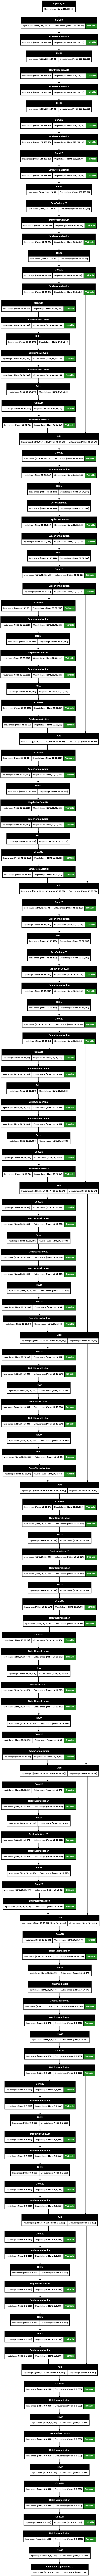

In [9]:
# Load a pre-trained MobileNetV2 model without the top layer,
# using 'imagenet' weights, and configure it for transfer learning
mobile = tfk.applications.MobileNetV2(
    input_shape = train_images.shape[1:],
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
)

# Plot the architecture of the MobileNetV2 model, displaying trainable parameters and the shapes of each layer
tfk.utils.plot_model(mobile, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "object_localization_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 1280)           │      2,257,984 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier (Dense)        │ (None, 2)              │          2,562 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ localizer (Dense)         │ (None, 4)              │          5,124 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

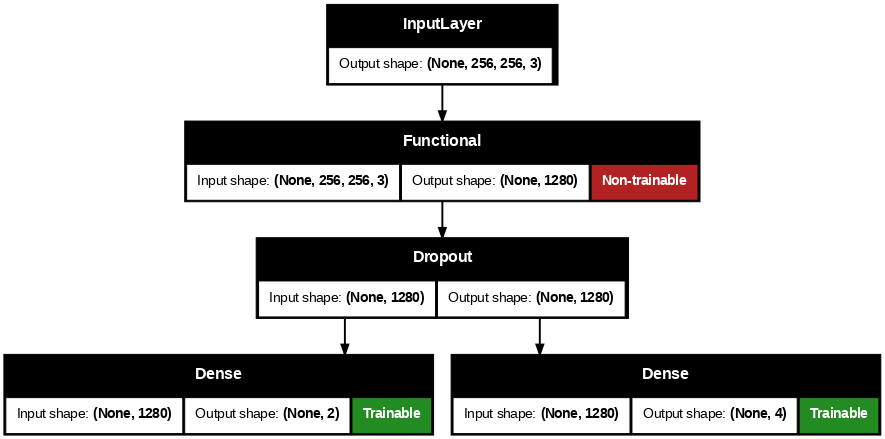

In [10]:
# Freeze MobileNet layers
mobile.trainable = False

# Define inputs and add MobileNet as a feature extractor
inputs = tfk.Input(shape=train_images.shape[1:])
x = mobile(inputs)

# Add dropout layer and classifier head for object classification
x = tfkl.Dropout(0.5, seed=seed)(x)
class_outputs = tfkl.Dense(2, activation='softmax', name='classifier')(x)

# Add localisation head for bounding box prediction
box_outputs = tfkl.Dense(4, activation='linear', name='localizer')(x)

# Create the model connecting inputs to classification and localisation outputs
object_localization_model = tfk.Model(inputs=inputs, outputs=[class_outputs, box_outputs], name='object_localization_model')

# Compile the model with categorical crossentropy and mean squared error losses, using Adam optimiser
object_localization_model.compile(loss=[tfk.losses.CategoricalCrossentropy(), tfk.losses.MeanSquaredError()], optimizer=tfk.optimizers.Adam())

# Display model summary and plot the model architecture
object_localization_model.summary()
tfk.utils.plot_model(object_localization_model, show_trainable=True, show_shapes=True, dpi=70)

In [11]:
# Model training with input images and associated labels and bounding boxes
object_localization_history = object_localization_model.fit(
    x = preprocess_input(train_images),
    y = [train_labels, train_boxes],
    batch_size = 64,
    epochs = 200,

    # Validation data provided for performance monitoring
    validation_data = (preprocess_input(val_images), [val_labels, val_boxes]),

    # Callbacks for early stopping and learning rate reduction based on validation loss
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1e-5)
    ]
).history

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 908ms/step - classifier_loss: 0.4869 - localizer_loss: 1.0164 - loss: 1.5033 - val_classifier_loss: 0.1556 - val_localizer_loss: 0.2415 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - classifier_loss: 0.1681 - localizer_loss: 0.6733 - loss: 0.8414 - val_classifier_loss: 0.0967 - val_localizer_loss: 0.1888 - val_loss: 0.2895 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - classifier_loss: 0.1160 - localizer_loss: 0.6084 - loss: 0.7244 - val_classifier_loss: 0.0898 - val_localizer_loss: 0.1784 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - classifier_loss: 0.0941 - localizer_loss: 0.5327 - loss: 0.6267 - val_classifier_loss: 0.0782 - val_localizer_loss: 0.1357 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - classifier_loss: 0.0853 - localizer_loss: 0.4226 - loss: 0.

In [12]:
# Save the best model
object_localization_model.save('MultitaskCatDogLocalizer.keras')
del object_localization_model

In [13]:
# Re-load the model after transfer learning
object_localization_model = tfk.models.load_model('MultitaskCatDogLocalizer.keras')
object_localization_model.summary()

Model: "object_localization_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 1280)           │      2,257,984 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier (Dense)        │ (None, 2)              │          2,562 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ localizer (Dense)         │ (None, 4)              │          5,124 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,281,044 (8.70 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 15,374 (60.06 KB)

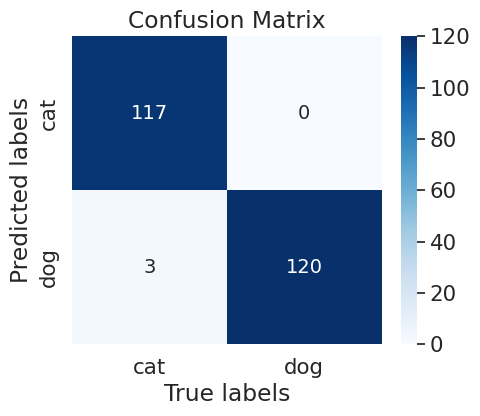

Accuracy score on validation set: 98.75
Precision score on validation set: 98.78
Recall score on validation set: 98.75
F1 score on validation set: 98.75
Spearman's Rho Correlation on validation set: 0.8118


In [14]:
# Generate predictions on the validation images
val_predictions = object_localization_model.predict(preprocess_input(val_images), verbose=0)
classification_predictions = np.argmax(val_predictions[0], axis=1)
box_predictions = val_predictions[1]

# Retrieve true labels from the validation set
val_gt = np.argmax(val_labels, axis=1)

# Compute and display confusion matrix
cm = confusion_matrix(val_gt, classification_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm.T, fmt='d', xticklabels=list(num_to_labels.values()),
            yticklabels=list(num_to_labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()

# Compute and display accuracy on the validation set
val_accuracy = accuracy_score(val_gt, classification_predictions)
print(f'Accuracy score on validation set: {round(val_accuracy*100, 2)}')

# Compute and display precision on the validation set
val_precision = precision_score(val_gt, classification_predictions, average='macro')
print(f'Precision score on validation set: {round(val_precision*100, 2)}')

# Compute and display recall on the validation set
val_recall = recall_score(val_gt, classification_predictions, average='macro')
print(f'Recall score on validation set: {round(val_recall*100, 2)}')

# Compute and display F1 score on the validation set
val_f1 = f1_score(val_gt, classification_predictions, average='macro')
print(f'F1 score on validation set: {round(val_f1*100, 2)}')

# Compute and display Spearman's Rho correlation for bounding box predictions
spearman = spearman_rho(val_boxes, box_predictions)
print(f'Spearman\'s Rho Correlation on validation set: {round(float(spearman),4)}')

#### 🕹️ Use the Model - Make Inference

In [15]:
# Load test images from the specified folder path with a target size of 256
test_path = 'localization_test/'
X_test = load_images_from_folder(test_path, 256)

In [16]:
# Display a sample of 10 images from the test data
num_img = 10
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i % 2, i % (num_img // 2)]
    ax.imshow(np.clip(X_test[i], 0, 255))
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Generate predictions on the test images
test_predictions = object_localization_model.predict(preprocess_input(X_test), verbose=0)

In [18]:
# Display a sample of 10 test images with predicted bounding boxes and class labels
num_img = 10
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i in range(num_img):
    row = i // (num_img // 2)
    col = i % (num_img // 2)
    ax = axes[row, col]

    # Extract bounding box predictions
    a1, b1, a2, b2 = test_predictions[1][i]
    img_size = 256

    # Rescale bounding box values to match image size
    x1 = a1 * img_size
    y1 = b1 * img_size
    x2 = a2 * img_size
    y2 = b2 * img_size

    img = X_test[i].copy()

    # Draw bounding boxes on the image
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

    # Get predicted class probabilities and label
    probabilities = test_predictions[0][i]
    predicted_class = np.argmax(probabilities)
    confidence = round(probabilities[predicted_class] * 100, 1)
    label = 'dog' if predicted_class == 1 else 'cat'

    # Display image with bounding box and label
    ax.imshow(np.clip(img, 0, 255).astype(np.uint8))
    ax.axis('off')
    ax.set_title(f'{label}: {confidence}%')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 🧠 Double Neural Network

**Image Classifier**

In [19]:
mobile = tfk.applications.MobileNetV2(
    input_shape = train_images.shape[1:],
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
)

In [20]:
# Use MobileNet as feature extractor
mobile.trainable = False

# Add the classifier to MobileNet
inputs = tfk.Input(shape=train_images.shape[1:])
x = mobile(inputs)
x = tfkl.Dropout(0.5, seed=seed)(x)
outputs = tfkl.Dense(2, activation='softmax', name='classifier')(x)

# Connect input and output through the Model class
classifier_model = tfk.Model(inputs=inputs, outputs=outputs, name='classifier_model')

# Compile the model
classifier_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
classifier_model.summary()

Model: "classifier_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (Dense)                   │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
# Train the model
classifier_history = classifier_model.fit(
    x = preprocess_input(train_images),
    y = train_labels,
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input(val_images), val_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=15, min_delta=1e-5)
    ]
).history

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.5711 - loss: 0.7999 - val_accuracy: 0.9583 - val_loss: 0.2138 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9214 - loss: 0.2481 - val_accuracy: 0.9750 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9579 - loss: 0.1452 - val_accuracy: 0.9792 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9571 - loss: 0.1173 - val_accuracy: 0.9833 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9724 - loss: 0.1077 - val_accuracy: 0.9833 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9695 - loss: 0.0883 - val_accuracy: 0.9833 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9676 - loss: 0

In [22]:
# Save the best model
classifier_model.save('CatDogClassifier.keras')
del classifier_model

In [23]:
# Re-load the model after transfer learning
classifier_model = tfk.models.load_model('CatDogClassifier.keras')
classifier_model.summary()

Model: "classifier_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (Dense)                   │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,672 (8.64 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 5,126 (20.03 KB)

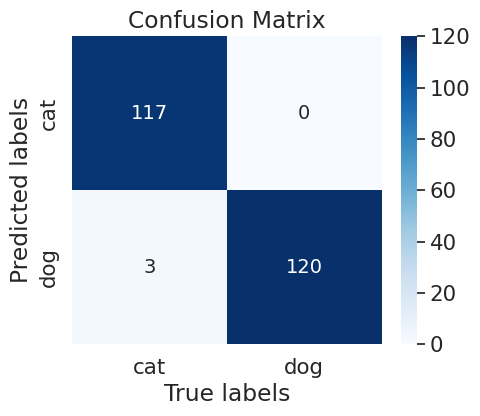

Accuracy score on validation set: 98.75
Precision score on validation set: 98.78
Recall score on validation set: 98.75
F1 score on validation set: 98.75


In [24]:
# Generate predictions on the validation images
val_predictions = classifier_model.predict(preprocess_input(val_images), verbose=0)
classification_predictions = np.argmax(val_predictions, axis=1)

# Retrieve true labels from the validation set
val_gt = np.argmax(val_labels, axis=1)

# Compute and display confusion matrix
cm = confusion_matrix(val_gt, classification_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm.T, fmt='d', xticklabels=list(num_to_labels.values()),
            yticklabels=list(num_to_labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()

# Compute and display accuracy on the validation set
val_accuracy = accuracy_score(val_gt, classification_predictions)
print(f'Accuracy score on validation set: {round(val_accuracy*100, 2)}')

# Compute and display precision on the validation set
val_precision = precision_score(val_gt, classification_predictions, average='macro')
print(f'Precision score on validation set: {round(val_precision*100, 2)}')

# Compute and display recall on the validation set
val_recall = recall_score(val_gt, classification_predictions, average='macro')
print(f'Recall score on validation set: {round(val_recall*100, 2)}')

# Compute and display F1 score on the validation set
val_f1 = f1_score(val_gt, classification_predictions, average='macro')
print(f'F1 score on validation set: {round(val_f1*100, 2)}')

**Box Regressor**

In [25]:
mobile = tfk.applications.MobileNetV2(
    input_shape = train_images.shape[1:],
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
)

In [26]:
# Use MobileNet as feature extractor
mobile.trainable = False

# Add the classifier to MobileNet
inputs = tfk.Input(shape=train_images.shape[1:])
x = mobile(inputs)
x = tfkl.Dropout(0.5, seed=seed)(x)
outputs = tfkl.Dense(4, activation='linear', name='box_regressor')(x)

# Connect input and output through the Model class
box_regressor_model = tfk.Model(inputs=inputs, outputs=outputs, name='box_regressor_model')

# Compile the model
box_regressor_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())
box_regressor_model.summary()

Model: "box_regressor_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ box_regressor (Dense)                │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
# Train the model
regressor_history = box_regressor_model.fit(
    x = preprocess_input(train_images),
    y = train_boxes,
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input(val_images), val_boxes),
    callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1e-5)
    ]
).history

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 555ms/step - loss: 1.1409 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.7713 - val_loss: 0.2278 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.6535 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.5884 - val_loss: 0.1422 - learning_rate: 0.0010
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.4942 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.4189 - val_loss: 0.1074 - learning_rate: 0.0010
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.3617 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.3343 - val_loss: 0.0855 - learning_rate: 0.0010
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.2823 - val_loss: 0.0759 - learning_rate: 0.0010

In [28]:
# Save the best model
box_regressor_model.save('CatDogBoxRegressor.keras')
del box_regressor_model

In [29]:
# Re-load the model after transfer learning
box_regressor_model = tfk.models.load_model('CatDogBoxRegressor.keras')
box_regressor_model.summary()

Model: "box_regressor_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ box_regressor (Dense)                │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,273,358 (8.67 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 10,250 (40.04 KB)

In [30]:
# Generate predictions for bounding box regression on validation images
predictions = box_regressor_model.predict(preprocess_input(val_images), verbose=0)

# Compute and display Spearman's Rho correlation between true and predicted bounding boxes
spearman = spearman_rho(val_boxes, predictions)
print(f"Spearman's Rho Correlation on validation set: {round(float(spearman), 4)}")

Spearman's Rho Correlation on validation set: 0.8487


#### 🕹️ Use the Model - Make Inference

In [31]:
# Load test images from the specified folder with the given image size
test_path = 'localization_test/'
X_test = load_images_from_folder(test_path, img_size)

In [32]:
# Display a sample of 10 test images
num_img = 10
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i in range(num_img):
    ax = axes[i % 2, i % (num_img // 2)]
    ax.imshow(np.clip(X_test[i], 0, 255))
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [33]:
# Generate class predictions and bounding box predictions on the test images
test_class_predictions = classifier_model.predict(preprocess_input(X_test), verbose=0)
test_box_predictions = box_regressor_model.predict(preprocess_input(X_test), verbose=0)

In [34]:
# Inspect the predictions
num_img = 10
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i in range(num_img):
    row = i // (num_img // 2)
    col = i % (num_img // 2)
    ax = axes[row, col]

    # Bounding box of each image
    a1, b1, a2, b2 = test_box_predictions[i]
    img_size = 256

    # Rescaling the bounding box values to match the image size
    x1 = a1 * img_size
    y1 = b1 * img_size
    x2 = a2 * img_size
    y2 = b2 * img_size

    img = X_test[i].copy()

    # Draw bounding boxes on the image
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

    # Get predicted probabilities
    probabilities = test_class_predictions[i]
    predicted_class = np.argmax(probabilities)
    confidence = round(probabilities[predicted_class] * 100, 1)
    label = 'dog' if predicted_class == 1 else 'cat'

    ax.imshow(np.clip(img, 0, 255).astype(np.uint8))
    ax.axis('off')
    ax.set_title(f'{label}: {confidence}%')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 👁️ Class Activation Maps

In [35]:
# Load test images from the specified folder and preprocess them
test_path = 'localization_test'
X_test = load_images_from_folder(test_path, img_size)
X_test_preprocessed = preprocess_input(X_test)

In [36]:
def compute_CAM(model, img):
    # Expand image dimensions to fit the model input shape
    img = np.expand_dims(img, axis=0)

    # Predict to get the winning class
    predictions = model.predict(img, verbose=0)
    label_index = np.argmax(predictions)

    # Get the 1028 input weights to the softmax of the winning class
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]

    # Define the final convolutional layer of the MobileNetV2 model
    final_conv_layer = tfk.Model(
        model.get_layer('mobilenetv2_1.00_224').input,
        model.get_layer('mobilenetv2_1.00_224').get_layer('Conv_1').output
    )

    # Compute the convolutional outputs and squeeze the dimensions
    conv_outputs = final_conv_layer(img)
    conv_outputs = np.squeeze(conv_outputs)

    # Upsample the convolutional outputs and compute the final output using the class weights
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1)
    final_output = np.dot(mat_for_mult.reshape((256*256, 1280)), class_weights_winner).reshape(256,256)

    return final_output, label_index, predictions

In [37]:
# Compute Class Activation Map (CAM) values for each image in the preprocessed test set
values = []
for img in X_test_preprocessed:
    values.append(compute_CAM(classifier_model, img))

In [ ]:
# Inspect the data
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20,9))
for i in range(num_img):
    ax = axes[i%2,i%num_img//2]
    ax.imshow(values[i][0], cmap='turbo')
    ax.imshow(np.clip(X_test[i], 0, 255), alpha=0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Display a sample of 10 test images with heatmap-based bounding boxes and class labels
num_img = 10
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i in range(num_img):

    # Extract the maximum value from the heatmap
    heatmap_max = np.max(values[i][0])

    # Define a threshold to filter heatmap values
    boundary = heatmap_max * 0.3

    # Apply the threshold to create a binary heatmap
    bbox_heatmap = values[i][0].copy()
    bbox_heatmap = np.where(bbox_heatmap <= boundary, 0, 255)

    bbox_img = X_test[i].copy()

    # Find contours of the heatmap
    cnts = cv2.findContours(bbox_heatmap.astype('uint8'),
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Define an offset for the bounding box
    offset = 10
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(bbox_img, (x + offset, y + offset),
                      (x + offset + w, y + h), (100, 255, 0), 3)

    # Get the predicted label and confidence score
    label = num_to_labels[values[i][1]]
    confidence = round(values[i][2][0][values[i][1]] * 100, 1)

    # Display image with bounding box and label
    ax = axes[i % 2, i % (num_img // 2)]
    ax.imshow(np.clip(bbox_img, 0, 255))
    ax.title.set_text(f'{label}: {confidence}%')
    ax.axis('off')

plt.tight_layout()
plt.show()